Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Friday, September 22, 2017.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Question 1

The data below provides counts of a flour beetle (Tribolium confusum) population at various points in time:

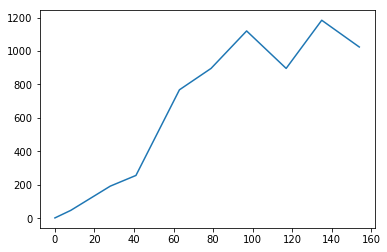

In [2]:
days = 0,8,28,41,63,79,97,117,135,154
beetles = 2,47,192,256,768,896,1120,896,1184,1024

plt.plot(days, beetles)

An elementary model for population growth is the logistic model:

$$\frac{dN}{dt} = rN\left(1 - \frac{N}{K}\right)$$

where $N$ is population size, $t$ is time, $r$ is a growth rate parameter, and $K$ is a parameter that represents the population carrying capacity of the environment. The solution to this differential equation is given by: 

$$N_t = f(t) = \frac{KN_0}{N_0 + (K - N_0)\exp(-rt)}$$

where $N_t$ denotes the population size at time $t$. 

1. Fit the logistic growth model to the flour beetle data using optimization to minimize the sum of squared errors between model predictions and observed counts.

2. In many population modeling applications, an assumption of lognormality is adopted. The simplest assumption would be that the $\log(N_t)$ are independent and normally distributed with mean $\log[f(t)]$ and variance $\sigma^2$. Find the MLEs under this assumption, and provide estimates of standard errors and correlation between them.

In [3]:
#function to calculate the logistic growth model at each time point t with parameters K and r and N_0 = beetles[0]
def logistic_model(K, r, t, N_0=beetles[0]):
    return ((K*N_0)/(N_0+(K-N_0)*np.exp(-r*t)))

#objective function is sum of squared errors between model prediction (from above) and observed count
def obj_func(KRarray, d=days, b= beetles):
    K,r = KRarray[0], KRarray[1]
    sq_err =[]
    for i in range(len(d)):
        sq_err.append((logistic_model(K,r, d[i], b[0])-b[i])**2)
    sse = sum(sq_err)
    return (sse)

In [4]:
#using Nelder-Mead algorithm to minimize the objective function 
from scipy import optimize

def nelder_mead(f, x0):
    output = []
    
    def store(X):
        output.append([X[0], X[1], f(X)])
        
    optimize.fmin(f, x0, callback=store, ftol=1e-12)
    
    return np.array(output)

In [5]:
K_0 = 1000
r_0 = 2
KRarray=np.array([K_0, r_0])
nm_output = nelder_mead(obj_func, KRarray)

Optimization terminated successfully.
         Current function value: 83240.486583
         Iterations: 117
         Function evaluations: 228


Using the last values for K and r (1033.5153172 0.117958558313, found by printing them in the logistic_model function and taking the last values in the list) we can plot the logistic model over the data to see how well it fits.

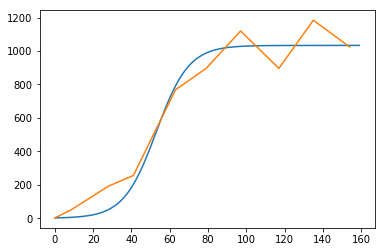

In [6]:
c=[]
for i in range(160):
    c.append(logistic_model(1033.5153172, 0.117958558313, i, beetles[0]))
plt.plot(range(160), c)
plt.plot(days, beetles)

### Answer 1.2

In this question, the model we are trying to fit is the log of the logistic model. I followed the below equations to come up with the log-likelihood function to optimize. We are assuming the data was generated from a normal distribution, and we want to find the mean (based on K and r from the logistic function, since mu = log(N(t))), and the standard deviation. The probability of the data is given by the normal pdf. When evaluating the log of the normal, this product of normal pdfs turns into a sum of mormal pdfs, which makes up the objective function. We want to find the MLEs for the three paramters so that this fits our data. 

![alt text](lognormality.png "Lognormality")

In [28]:
import scipy.stats as ss
def log_likelihood(Krs_array, d = days, b = beetles):
    K,r, s = Krs_array[0], Krs_array[1], Krs_array[2]
    sums=0
    for i in range(len(b)):
        #alpha = mean of the normal = log(N)
        alpha = np.log(logistic_model(K, r, d[i], N_0=beetles[0]))
        sums = sums + (float(b[i])-alpha)**2
    return -(len(b)*np.log(1/(np.sqrt(2*np.pi)))-len(b)*np.log(abs(s))-(1/(2*s**2))*sums)


In [29]:
from scipy import optimize

def nelder_mead(f, x0):
    output = []
    
    def store(X):
        output.append([X[0], X[1], X[2], f(X)])
        
    optimize.fmin(f, x0, callback=store, ftol=1e-12)
    
    return np.array(output)

In [30]:
K_0 = 1033
r_0 = .11
sigma = .3
Krs_array=np.array([K_0, r_0, sigma])
nm_output = nelder_mead(log_likelihood, Krs_array)



/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log


The Nelder-Mead algorithm ran, and it ended with K = 1247, r = .142, and s = 3.6 x 10^-32 (approximately 0).

> Looks great but missing sds and correlations between mles.

> 20/25

## Question 2

1. Implement simulated annealing for minimizing the AIC for the baseball salary regression problem. Model your algorithm on the example given in class. 

    1. Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).  
    2. Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

2. Implement a genetic algorithm for minimizing the AIC for the baseball salary regression problem. Model your algorithm on Example 3.5. 

    1. Compare the effects of using different mutation rates.  
    2. Compare the effects of using different generation sizes.  
    3. Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.



In [4]:
baseball = pd.read_table('../Bios8366/data/baseball.dat', sep='\s+')

### Part 1 Answer

Everything below is from class. It shows a simulated annealing method for minimizing the AIC for the baseball salary regression problem. It starts with a cooling schedule in which tau_start (10) is the temperature for 60 iterations, and then half the temp for twice as long, and then again. This is the schedule we used in class.

In [5]:
#Simulated annealing to minimize the AIC
predictors = baseball.copy()
logsalary = predictors.pop('salary').apply(np.log)
nrows, ncols = predictors.shape

#Start from 5 different positions and run each 15 iterations
nstarts = 5
iterations = 15

#AIC Metric
aic = lambda g, X, y: len(y) * np.log(sum((g.predict(X) - y)**2)/len(y)) + 2*g.rank_

In [47]:
from sklearn.linear_model import LinearRegression
tau_start = 10
num_flips=1
#amount of time for first annealing temperature
len1 = 60
len2 = 120
len3 = 240

In [54]:
def simulated_annealing(tau_start, len1, len2, len3, num_flips):
    aic_values = []
    #initialize the solution to randomly include or not include variables in the regression model
    solution_current = solution_best = np.random.binomial(1, 0.5, ncols).astype(bool)
    solution_vars = predictors[predictors.columns[solution_current]]
    #instantiate a linear regression object and fitting it
    g = LinearRegression().fit(X=solution_vars, y=logsalary)
    aic_best = aic(g, solution_vars, logsalary)
    aic_values.append(aic_best)
    cooling_schedule = [tau_start]*len1 + [tau_start/2]*len2 + [tau_start/10]*len3
    for tau in cooling_schedule:

        # Random change 1-neighborhood
        for i in range(num_flips):
            flip = np.random.randint(0, ncols)
            #just change what variables are included and which are excluded
            solution_current[flip] = not solution_current[flip]
        solution_vars = predictors[predictors.columns[solution_current]]
        g = LinearRegression().fit(X=solution_vars, y=logsalary)
        aic_step = aic(g, solution_vars, logsalary)
        #probability of accepting a new solution
        alpha = min(1, np.exp((aic_values[-1] - aic_step)/tau))

        #if it's better or if you probabilistically choose the new solution:
        if ((aic_step < aic_values[-1]) or (np.random.uniform() < alpha)):
            # Accept proposed solution
            aic_values.append(aic_step)
            if aic_step < aic_best:
                # Replace previous best with this one
                aic_best = aic_step
                solution_best = solution_current.copy()
        else:
            # Revert solution
            solution_current[flip] = not solution_current[flip]
            aic_values.append(aic_values[-1])
    return(aic_values, aic_best, solution_best)

Best AIC: -418.27169950506504
Best solution: (array([ 2,  5,  7,  9, 12, 13, 19, 20, 21, 24]),)
Discovered at iteration 305


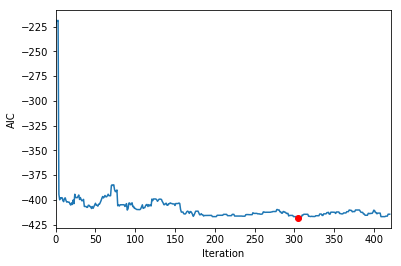

In [55]:
aic_values,aic_best,solution_best=simulated_annealing(tau_start, len1, len2, len3, num_flips)
plt.plot(aic_values)
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
            np.where(solution_best==True),
            np.where(aic_values==aic_best)[0][0]))
plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')

### Answer to Question 2.1A
Compare the effects of different cooling schedules (different temperatures and different durations at each temperature).

First we can compare the effect of different starting temperatures.

5
10
15
20
25


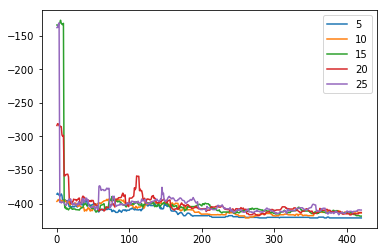

In [56]:
tau_list=np.arange(5,30, 5)
comparisons = pd.DataFrame(columns=["Tau_Start","Best_AIC", "Iteration"])
for t in tau_list:
    print(t)
    aic_values,aic_best,solution_best=simulated_annealing(t, len1, len2, len3, num_flips)
    plt.plot(aic_values, label = t)
    df1 = pd.DataFrame([[t, aic_best, np.where(aic_values==aic_best)[0][0]]],columns=["Tau_Start", "Best_AIC", "Iteration"])
    comparisons=comparisons.append(df1)
plt.legend()
plt.show()

In [57]:
comparisons


,Tau_Start,Best_AIC,Iteration
0,5.0,-420.947211,369.0
0,10.0,-420.947211,260.0
0,15.0,-418.265145,418.0
0,20.0,-417.548904,277.0
0,25.0,-416.385881,389.0


There doesn't seem to be a pattern of annealing time (iteration of best AIC) or the best AIC value depending on the starting temperature. However, the lower initial temperature means that the AIC value doesn't jump around as much and starts at a lower value.

Next, we can try different lengths of time for each temperature. In class, the cooling schedule had lengths: len1 = 60, len2 = 120, len3 = 240. Here, we can try two more schedules: one that has a longer len1 (at high temp) and shorter len3 (at low temp), and one that has the same lengths at each temperature.


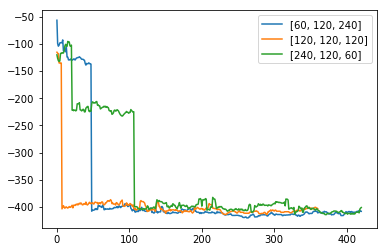

In [73]:
t=20
len1 = 60
len2 = 120
len3 = 240
comparisons = pd.DataFrame(columns=["Lengths","Best_AIC", "Iteration"])
aic_values,aic_best,solution_best=simulated_annealing(t, len1, len2, len3, num_flips)
plt.plot(aic_values, label = str([len1, len2, len3]))
df1 = pd.DataFrame([[str([len1, len2, len3]), aic_best, np.where(aic_values==aic_best)[0][0]]],columns=["Lengths", "Best_AIC", "Iteration"])
comparisons=comparisons.append(df1)
len1= len2= len3 = 120
aic_values,aic_best,solution_best=simulated_annealing(t, len1, len2, len3, num_flips)
plt.plot(aic_values, label = str([len1, len2, len3]))
df1 = pd.DataFrame([[str([len1, len2, len3]), aic_best, np.where(aic_values==aic_best)[0][0]]],columns=["Lengths", "Best_AIC", "Iteration"])
comparisons=comparisons.append(df1)
len1 = 240
len2 = 120
len3= 60
aic_values,aic_best,solution_best=simulated_annealing(t, len1, len2, len3, num_flips)
plt.plot(aic_values, label = str([len1, len2, len3]))
df1 = pd.DataFrame([[str([len1, len2, len3]), aic_best, np.where(aic_values==aic_best)[0][0]]],columns=["Lengths", "Best_AIC", "Iteration"])
comparisons=comparisons.append(df1)
plt.legend()
plt.show()

In [71]:
comparisons

,Lengths,Best_AIC,Iteration
0,"[60, 120, 240]",-415.286955,357.0
0,"[120, 120, 120]",-414.076847,286.0
0,"[240, 120, 60]",-415.900924,410.0


### Answer to Question 2.1B
Compare the effect of a proposal distribution that is discrete uniform over 2-neighborhoods versus one that is discrete uniform over 3-neighborhoods.

Best AIC: -409.6648825620759
Best solution: (array([ 2,  3,  4,  6,  7,  8,  9, 12, 13, 15, 16, 17, 18, 19, 20, 21, 26]),)
Discovered at iteration 150


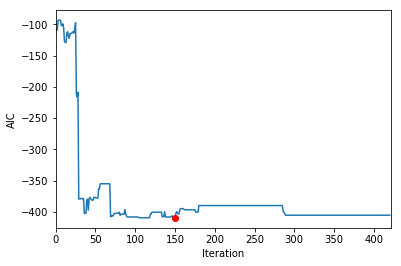

In [76]:
tau_start = 10
len1 = 60
len2 = 120
len3 = 240
aic_values,aic_best,solution_best=simulated_annealing(tau_start, len1, len2, len3, 2)

plt.plot(aic_values)        
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
            np.where(solution_best==True),
            np.where(aic_values==aic_best)[0][0]))
plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')

Best AIC: -412.4215046434421
Best solution: (array([ 1,  2,  5,  7,  8, 12, 13, 14, 15, 16, 17, 21, 23, 24, 25]),)
Discovered at iteration 303


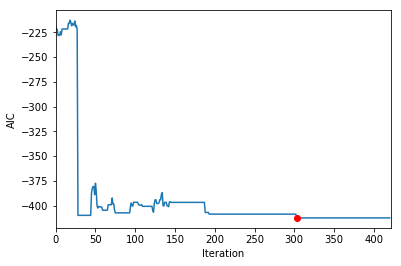

In [79]:
tau_start = 10
len1 = 60
len2 = 120
len3 = 240
aic_values,aic_best,solution_best=simulated_annealing(tau_start, len1, len2, len3, 3)

plt.plot(aic_values)        
plt.xlim(0, len(aic_values))
plt.xlabel('Iteration')
plt.ylabel('AIC')
print('Best AIC: {0}\nBest solution: {1}\nDiscovered at iteration {2}'.format(aic_best, 
            np.where(solution_best==True),
            np.where(aic_values==aic_best)[0][0]))
plt.plot(np.where(aic_values==aic_best)[0][0], aic_best, 'ro')

### Part 2 Answer
GA modeled off of example 3.5

In [80]:
pop_size = 20
iterations = 100
#probability of mutation at each iteration
mutation_rate = .02

In [24]:
def calculate_fitness(aic_values):
    P = len(aic_values)
    #weight negative sorted AIC values
    aic_rank = (-aic_values).argsort().argsort()+1.
    return 2.*aic_rank/(P*(P+1.))

In [82]:
def GA(pop_size, iterations, mutation_rate):
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    aic_best = []
    best_solution = []
    aic_history = []

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose first parents according to fitness (p = passes in a weight for selection)
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        # Choose second parents randomly (to introduce more randomness and changes the rate of exploitation vs. exploration)
        dads = np.random.choice(range(pop_size), size=int(pop_size/2))

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return (aic_best, best_solution, aic_history)

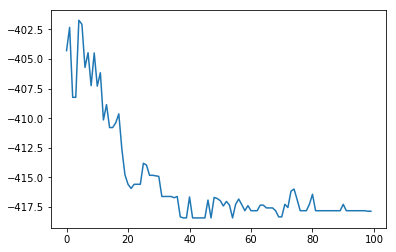

In [83]:
aic_best, best_solution, aic_history = GA(pop_size, iterations, mutation_rate)
plt.plot(aic_best)

### Answer to Question 2.2A
Compare the effects of using different mutation rates.

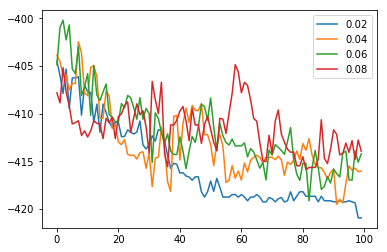

In [84]:
mutation_rate = np.arange(0.02, .10, 0.02)
for m in mutation_rate:
    aic_best, best_solution, aic_history = GA(pop_size, iterations, m)
    plt.plot(aic_best, label = str(m))
plt.legend()
plt.show()

Increasing the mutation rate adds in a lot more noise and keeps the AIC values from effectively reaching a minimum.

### Answer to Question 2.2B
Compare the effects of using different generation sizes.

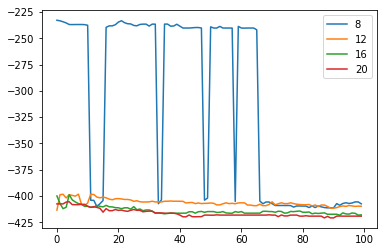

In [85]:
pop_size = np.arange(8,24,4)
mutation_rate=.02
for p in pop_size:
    aic_best, best_solution, aic_history = GA(p, iterations, mutation_rate)
    plt.plot(aic_best, label = str(p))
plt.legend()
plt.show()

Increasing the generation size makes the algorithm reach a lower AIC faster, and less sporadically. 

### Answer to Question 2.2C
Instead of the selection mechanism used in the class example, try using independent selection of both parents with probabilities proportional to their fitness.

In [86]:
def GA_both_parents(pop_size, iterations, mutation_rate):
    current_gen = np.random.binomial(1, 0.5, pop_size*ncols).reshape((pop_size, ncols))
    aic_best = []
    best_solution = []
    aic_history = []

    for i in range(iterations):

        # Get phenotype
        current_phe = [predictors[predictors.columns[g.astype(bool)]] for g in current_gen]
        # Calculate AIC
        current_aic = np.array([aic(LinearRegression().fit(X=x, y=logsalary), x, logsalary) for x in current_phe])
        # Get lowest AIC
        aic_best.append(current_aic[np.argmin(current_aic)])
        best_solution.append(current_gen[np.argmin(current_aic)])

        # Calculate fitness according to AIC rank
        fitness = calculate_fitness(current_aic)

        # Choose both parents according to fitness (p = passes in a weight for selection)
        moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
        dads = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)

        next_gen = []
        for x,y in zip(current_gen[moms], current_gen[dads]):
            # Crossover
            cross = np.random.randint(0, ncols)
            child1 = np.r_[x[:cross], y[cross:]]
            child2 = np.r_[y[:cross], x[cross:]]
            # Mutate
            m1 = np.random.binomial(1, mutation_rate, size=ncols).astype(bool)
            child1[m1] = abs(child1[m1]-1)
            m2 = np.random.binomial(1, mutation_rate, size=ncols)
            child2[m2] = abs(child1[m2]-1)
            next_gen += [child1, child2]

        # Increment generation
        current_gen = np.array(next_gen)
        # Store AIC values
        aic_history.append(current_aic)
    return (aic_best, best_solution, aic_history)

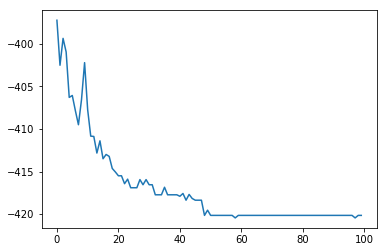

In [90]:
pop_size = 20
iterations = 100
#probability of mutation at each iteration
mutation_rate = .02
aic_best, best_solution, aic_history = GA_both_parents(pop_size, iterations, mutation_rate)
plt.plot(aic_best)

With the two parents being chosen based on fitness, the "best" AIC should be approached faster-- however, it is more likely to be a local minimum rather than global. Having one parent chosen randomly allows for more freedom to jump out of a local minimum and explore regions that may not be as fit, but may be in the neighbrhood of the tru global minimum.

> Okay, nice work

> 25/25

## Question 3

Use the combinatorial optimization method of your choice to obtain a solution to the traveling salesman problem for the Brazilian cities described in the lecture notes, using minimum total distance as the criterion. Use the the first city listed in the dataset as "home" (*i.e.* the trip must start and end there). I will award 5 bonus points to the best solution!

In [2]:
def parse_latlon(x):
    d, m, s = map(float, x.split(':'))
    ms = m/60. + s/3600.
    if d<0:
        return d - ms
    return d + ms

cities =  pd.read_csv('data/brasil_capitals.txt', 
                      names=['city','lat','lon'])[['lat','lon']].applymap(parse_latlon)

In [3]:
cities


,lat,lon
0,60.673333,2.819722
1,51.066389,0.038889
2,48.504444,-1.455833
3,44.302778,-2.529722
4,60.025000,-3.101944
5,38.543056,-3.717222
6,42.801944,-5.089167
7,35.209444,-5.795000
8,34.863056,-7.115000
9,34.881111,-8.053889


In [4]:
#criterion = minimal total distance
#sqrt(abs(lat1-lat2)^2+abs(lon1-lon2)^2) minimized
#each state = order of 25 places --> list of ordinals for each place ordered_list=[1,2,3,4...,25] is one option for ordering the places
#each state must start and end with 0, so we can remove this from the state space
#for example, in ordered_list, city with index 1 is second (after 0)... if o_l = [3,...], the second city is 3
#criteria for each state = sum of distances between ordered_list[i] and ordered_list[i+1]
distance = lambda lat1, lat2, lon1, lon2: np.sqrt((abs(lat1-lat2))**2+(abs(lon1-lon2))**2)
def calculate_distances(phenotype, cities):
#find distance from 0 to first in phenotype and last in phenotype to 0 and add to sum variable
#return as distance
#cities.iloc[0].lat = gives latitude for first city in cities
    sum_dist = distance(cities.iloc[0].lat, cities.iloc[phenotype[0, 0]].lat, cities.iloc[0].lon, cities.iloc[phenotype[0,0]].lon)
    sum_dist = sum_dist + distance(cities.iloc[0].lat, cities.iloc[phenotype[0, phenotype.shape[1]-1]].lat, cities.iloc[0].lon, cities.iloc[phenotype[0, phenotype.shape[1]-1]].lon)
    #loop over i from phenotype[0] to phenotype[last-1] and add distance between i and i+1 to sum
    for i in range(phenotype.shape[1]-1):
        #print(i, cities.iloc[phenotype[0, i]].lat, cities.iloc[phenotype[0, i+1]].lat, cities.iloc[phenotype[0, i]].lon, cities.iloc[phenotype[0, i+1]].lon)
        sum_dist = sum_dist+distance(cities.iloc[phenotype[0, i]].lat, cities.iloc[phenotype[0, i+1]].lat, cities.iloc[phenotype[0, i]].lon, cities.iloc[phenotype[0, i+1]].lon)
    return sum_dist
#highest fitness = highest number e.g. 20. lowest fitness = lowest number e.g 1.
def calculate_fitness(distances_list):
    P = len(distances_list)
    dist_rank = (-distances_list).argsort().argsort()+1.
    return 2.*dist_rank/(P*(P+1.))
    

In [5]:
pop_size = 20
iterations = 300
mutation_rate = .02

In [6]:
dist_best = []
best_solution = []
dist_history = []
nrows, ncols = cities.shape
current_gen = (np.arange(nrows-1)+1)
np.random.shuffle(current_gen)
current_gen=np.array([current_gen])
for i in range(pop_size-1):
    phen = (np.arange(nrows-1)+1)
    np.random.shuffle(phen)
    phen=np.array([phen])
    current_gen=np.append(current_gen,phen,axis=0)
for j in range(current_gen.shape[0]):
    c=calculate_distances(np.array([current_gen[j]]), cities)
    print(c)
print(current_gen)

388.948138245
418.351796815
486.920820876
442.01712555
406.521874272
449.013610292
474.821738073
450.426193267
394.326088188
398.580240812
383.063063194
450.639868728
438.849471981
441.744181507
432.809236597
421.402578986
413.508420114
438.543888081
400.603754036
441.000591677
[[12  6  5  9 19 10 13 23 20 22 11  3 25 21 18  4 16 14  7 17 24  2  8  1
  15]
 [15  9  8 20 18 10 22 14 21 24 12  1  7  3 25 17 19  4  2 13  6 23 11  5
  16]
 [23 10 24 16  9 15  6  8  1 21 11 19 12 13 18  4  7 20  2  3 25 14 22 17
   5]
 [19 22 16  9  1 18 23 15 25  4 10 21  2 20  6 24 11 13 17  8  5  3 12  7
  14]
 [ 1 24 11 25 22  9 16 14 21 20  3 10  4 13  7 15  8  5 18 19  6  2 12 23
  17]
 [15  8 21 17 25 20  7  9 11  2 22  5 10 24 13  3 18 12  4 14 16  1 19  6
  23]
 [ 6 23  2 17 14 24 15 11 22 12  1 13 16  5 21  8  4  7 25 20  3 10 18 19
   9]
 [14 19 11  7 25  8 12  2  3 16 15  9 18 24  1  6  5 23  4 22 10 17 13 20
  21]
 [24  7  8 11  9 21  6 12 20  5 19 22  1 18 13 23 16 14  3 10 25 17 15  4
   2]
 

In [7]:
for i in range(iterations):
    c=[]
    for j in range(current_gen.shape[0]):
        c.append(calculate_distances(np.array([current_gen[j]]), cities))
    # Get lowest AIC
    dist_best.append(min(c))
    best_solution.append(current_gen[c.index(min(c))])
    # Calculate fitness according to AIC rank
    fitness = calculate_fitness(np.array(c))
    # Choose first parents according to fitness (p = passes in a weight for selection)
    moms = np.random.choice(range(pop_size), size=int(pop_size/2), p=fitness)
    # Choose second parents randomly (to introduce more randomness and changes the rate of exploitation vs. exploration)
    dads = np.random.choice(range(pop_size), size=int(pop_size/2))
    
    next_gen = []
    for x,y in zip(current_gen[moms], current_gen[dads]):
        # Crossover
        cross = np.random.randint(0, ncols)
        #child1: for child 1, the first half of the mom becomes the beginning. The second half of dad becomes the end.
        #For each x in the first half, find x already in dad (the second half) and swap
        child1 = x
        child2 = y
        child1_old_save = child1
        for q in range(cross):
            #child1 = np.r_[x[:cross], y[cross:]]
            swap = child1[q] #save the mom variable as swap
            save = child2[q] #the one to be replaced
            ind = list(child1).index(y[q]) #this is where the swap variable moves to
            child1[ind] = swap 
            child1[q] = save 
        for r in range(cross):
            #child1 = np.r_[x[:cross], y[cross:]]
            swap = child2[r] #save the mom variable as swap
            save = child1_old_save[r] #the one to be replaced
            ind = list(child2).index(y[r]) #this is where the swap variable moves to
            child2[ind] = swap 
            child2[r] = save 
        # Mutate: flip two cities within the child
        if np.random.binomial(1, mutation_rate):
            swap_1=np.random.choice(len(child1))
            swap_2=np.random.choice(len(child1))
            x = child1[swap_1]
            y = child1[swap_2]
            child1[swap_1]=y
            child1[swap_2]=x
        if np.random.binomial(1, mutation_rate):
            swap_1=np.random.choice(len(child2))
            swap_2=np.random.choice(len(child2))
            x = child2[swap_1]
            y = child2[swap_2]
            child2[swap_1]=y
            child2[swap_2]=x
        next_gen += [child1, child2]
        
    # Increment generation
    current_gen = np.array(next_gen)
    # Store AIC values
    dist_history.append(c)

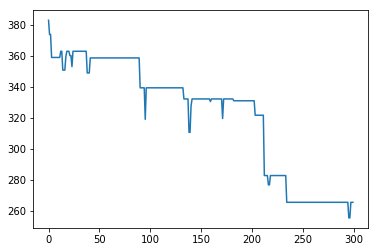

In [8]:
plt.plot(dist_best)

In [9]:
min(dist_best)

255.61860773253875

In [16]:
best_solution[dist_best.index(255.61860773253875)]

array([ 5,  7,  8, 11,  9, 21, 22, 24, 23, 16, 10, 14, 19, 18, 13, 20, 25,
        6,  3,  2,  1, 17, 15,  4, 12])

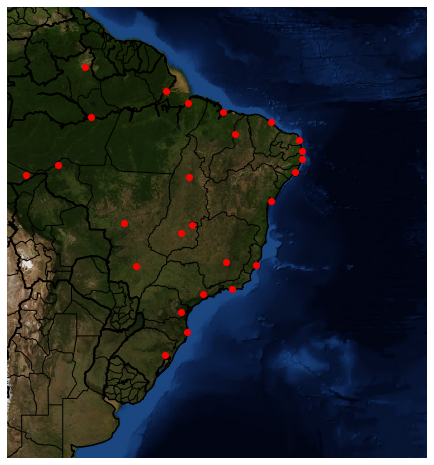

In [43]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')
from mpl_toolkits.basemap import Basemap

xmin, xmax, ymin, ymax = -70.0, -20.0, -40.0, 10.0

fig = plt.figure(figsize=(11.7,8.3))
bm = Basemap(projection='merc', \
             llcrnrlon=xmin, llcrnrlat=ymin, \
             urcrnrlon=xmax, urcrnrlat=ymax, \
             lon_0=0.5*(xmax + xmin), lat_0=0.5*(ymax + ymin), \
             resolution='l', area_thresh=1000000)
    
bm.drawcoastlines(linewidth=1.5)
bm.bluemarble()
bm.drawcountries(linewidth=2)
bm.drawstates(linewidth=1)
x = [cities.loc[i].lat for i in best_solution[dist_best.index(255.61860773253875)]]
x.append(x[0])
y = [cities.loc[i].lon for i in best_solution[dist_best.index(255.61860773253875)]]
y.append(y[0])
bm.plot(x, y, marker=None, color = 'm', latlon=True)
bm.plot(x[0],y[0], 'bo', latlon=True)
for i,c in cities.iterrows():
    bm.plot(-c['lat'], c['lon'], 'ro', latlon=True)

Hmmm I'm not seeing a path plotted on your map...

In [9]:
min(dist_best)

275.69530480230287

>Nice work

>25/25

## Question 4

The `../data/ebola` folder contains summarized reports of Ebola cases from three countries during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

From these data files, use `pandas` to import them and create a single data frame that includes the daily totals of new cases and deaths for each country.

In [3]:
# Write your answer here
!ls data/ebola

LICENSE      guinea_data  liberia_data sl_data


In [4]:
!ls data/ebola/guinea_data

2014-08-04.csv 2014-09-02.csv 2014-09-11.csv 2014-09-21.csv 2014-09-30.csv
2014-08-26.csv 2014-09-04.csv 2014-09-14.csv 2014-09-22.csv 2014-10-01.csv
2014-08-27.csv 2014-09-07.csv 2014-09-16.csv 2014-09-23.csv
2014-08-30.csv 2014-09-08.csv 2014-09-17.csv 2014-09-24.csv
2014-08-31.csv 2014-09-09.csv 2014-09-19.csv 2014-09-26.csv


In [314]:
#use pandas to import them 
import os
guinea_data = pd.DataFrame()
path = "data/ebola/guinea_data"
for filename in os.listdir("data/ebola/guinea_data"):
    df=pd.read_csv(os.path.join(path, filename))
    guinea_data = guinea_data.append(df)
liberia_data = pd.DataFrame()
path = "data/ebola/liberia_data/"
for filename in os.listdir("data/ebola/liberia_data/"):
    df=pd.read_csv(os.path.join(path, filename))
    liberia_data = liberia_data.append(df)
sl_data=pd.DataFrame()
path = "data/ebola/sl_data/"
for filename in os.listdir("data/ebola/sl_data/"):
    df=pd.read_csv(os.path.join(path, filename))
    sl_data = sl_data.append(df)

In [315]:
#create a single data frame that includes the daily totals of new cases and daily totals of deaths for each country.
guinea_data = guinea_data.loc[:, ['Date', 'Description','Totals']]
liberia_data = liberia_data.loc[:, ["Date", "Variable", "National"]]
sl_data=sl_data.loc[:,['date', "variable", 'National']]
(sl_data.head(), guinea_data.head(), liberia_data.head())

(         date       variable National
 0  2014-08-12     population  6348350
 1  2014-08-12    new_noncase        4
 2  2014-08-12  new_suspected       10
 3  2014-08-12   new_probable        1
 4  2014-08-12  new_confirmed       11,
          Date                        Description Totals
 0  2014-08-04              New cases of suspects      5
 1  2014-08-04             New cases of probables      0
 2  2014-08-04             New cases of confirmed      4
 3  2014-08-04  Total new cases registered so far      9
 4  2014-08-04            Total cases of suspects     11,
         Date                          Variable  National
 0  6/16/2014               Specimens collected       1.0
 1  6/16/2014     Specimens pending for testing       0.0
 2  6/16/2014            Total specimens tested      28.0
 3  6/16/2014             Newly reported deaths       2.0
 4  6/16/2014  Total death/s in confirmed cases       8.0)

In [316]:
#parse the dates so that they are alli nthe same format
from dateutil.parser import parse
from datetime import datetime
#liberia_data.Date.apply(lambda d: datetime.strptime(d, '%m/%d/%y')) 
liberia_data.Date = pd.to_datetime(liberia_data.Date)
sl_data.date = pd.to_datetime(sl_data.date)
guinea_data.Date = pd.to_datetime(guinea_data.Date)

In [317]:
(sl_data.head(), guinea_data.head(), liberia_data.head())

(        date       variable National
 0 2014-08-12     population  6348350
 1 2014-08-12    new_noncase        4
 2 2014-08-12  new_suspected       10
 3 2014-08-12   new_probable        1
 4 2014-08-12  new_confirmed       11,
         Date                        Description Totals
 0 2014-08-04              New cases of suspects      5
 1 2014-08-04             New cases of probables      0
 2 2014-08-04             New cases of confirmed      4
 3 2014-08-04  Total new cases registered so far      9
 4 2014-08-04            Total cases of suspects     11,
         Date                          Variable  National
 0 2014-06-16               Specimens collected       1.0
 1 2014-06-16     Specimens pending for testing       0.0
 2 2014-06-16            Total specimens tested      28.0
 3 2014-06-16             Newly reported deaths       2.0
 4 2014-06-16  Total death/s in confirmed cases       8.0)

### SL Data
Because of the column names in the SL data, we need to manually add the "new_suspected", "new_probable", and "new_confirmed" cases to get a column of new cases for each date. 

In [318]:
sl_ns= sl_data[sl_data.variable.str.contains("new_suspected")]
sl_ns=sl_ns.rename(columns = {'National':'new_suspected'})
sl_ns.index = sl_ns.date
sl_nc = (sl_data[sl_data.variable.str.contains("new_confirmed")])
sl_nc = sl_nc.rename(columns={'National': 'new_confirmed'})
sl_nc.index = sl_nc.date
sl_np = (sl_data[sl_data.variable.str.contains("new_probable")])
sl_np = sl_np.rename(columns={'National': 'new_probable'})
sl_np.index = sl_np.date
#sl_reduced=sl_reduced.append(sl_data[sl_data.variable.str.contains("new_confirmed")])

In [319]:
sl_ns=sl_ns.drop(['date', 'variable'], axis=1)
sl_np=sl_np.drop(['date', 'variable'], axis=1)
sl_nc=sl_nc.drop(['date', 'variable'], axis=1)

In [320]:
sl_case=sl_ns.new_suspected.astype(float).add(sl_np.new_probable.astype(float), fill_value=0).add(sl_nc.new_confirmed.astype(float), fill_value=0)
sl_case.name = "SL New Cases"

We then must do the same with the "death_suspected", "death_probable", and "death_confirmed" columns. However, these columns are actually cumulative, so we'll need to subtract each value by the one above it to get the number of new casses on that day. The first value in the New Death SL series will actually be the cumulative deaths up until that date, because there is no way to know how many deaths occured on that day from the limited data set. Then we will have two pandas series: one called "New Cases" indexed by date, and one called "New deaths" indexed by date. we can combine these into one dataframe so that we have new cases and new deaths for sierra leone data indexed by date.

In [321]:
sl_ns= sl_data[sl_data.variable.str.contains("death_suspected")]
sl_ns=sl_ns.rename(columns = {'National':'death_suspected'})
sl_ns.index = sl_ns.date
sl_nc = (sl_data[sl_data.variable.str.contains("death_confirmed")])
sl_nc = sl_nc.rename(columns={'National': 'death_confirmed'})
sl_nc.index = sl_nc.date
sl_np = (sl_data[sl_data.variable.str.contains("death_probable")])
sl_np = sl_np.rename(columns={'National': 'death_probable'})
sl_np.index = sl_np.date
sl_ns=sl_ns.drop(['date', 'variable'], axis=1)
sl_np=sl_np.drop(['date', 'variable'], axis=1)
sl_nc=sl_nc.drop(['date', 'variable'], axis=1)
sl_death=sl_ns.death_suspected.astype(float).add(sl_np.death_probable.astype(float), fill_value=0).add(sl_nc.death_confirmed.astype(float), fill_value=0)
sl_death.name = "SL New Deaths"
print(sl_death.head(10))
for i in range(len(sl_death)):
    sl_death[-i]=sl_death[-i]-sl_death[-i-1]
sl_death[0]=303
sl_death[1]=9

date
2014-08-12    303.0
2014-08-13    312.0
2014-08-14    319.0
2014-08-15    326.0
2014-08-16    336.0
2014-08-17    344.0
2014-08-18    351.0
2014-08-19    359.0
2014-08-20    361.0
2014-08-21    371.0
Name: SL New Deaths, dtype: float64


In [349]:
sl_all = pd.concat([sl_case, sl_death], axis = 1)
sl_all=sl_all.fillna(0)
sl_all.head(20)

,SL New Cases,SL New Deaths
date,,
2014-08-12,22.0,303.0
2014-08-13,19.0,9.0
2014-08-14,15.0,7.0
2014-08-15,17.0,7.0
2014-08-16,21.0,10.0
2014-08-17,3.0,8.0
2014-08-18,60.0,7.0
2014-08-19,28.0,8.0
2014-08-20,5.0,2.0


### Guinea Data
Next we'll move on to tidying up the Guinea data. Luckily, this data set has two columns already for "New deaths registered today" and "Total new cases registered so far" that already sum over the suspected, probable, and confirmed cases. 

In [323]:
guinea_data.Description.head(20)

0                               New cases of suspects
1                              New cases of probables
2                              New cases of confirmed
3                   Total new cases registered so far
4                             Total cases of suspects
5                            Total cases of probables
6                            Total cases of confirmed
7        Cumulative (confirmed + probable + suspects)
8                         New deaths registered today
9             New deaths registered today (confirmed)
10            New deaths registered today (probables)
11             New deaths registered today (suspects)
12                           Total deaths of suspects
13                          Total deaths of probables
14                          Total deaths of confirmed
15    Total deaths (confirmed + probables + suspects)
16                             Total PEC center today
17                 Total PEC center today (confirmed)
18                 Total PEC

In [398]:
g_nd= guinea_data[guinea_data.Description=="New deaths registered"]
g_nd=g_nd.append(guinea_data[guinea_data.Description=="New deaths registered today"])
g_nd=g_nd.rename(columns = {'Totals':'G New Deaths'})
g_nd.index = g_nd.Date
#g_nd=g_nd.drop(['Date', 'Description'], axis=1)
g_death = pd.Series(g_nd["G New Deaths"].astype(float))

In [399]:
g_nc= guinea_data[guinea_data.Description.str.contains("Total new cases registered so far")]
g_nc=g_nc.rename(columns = {'Totals':'G New Cases'})
g_nc.index = g_nc.Date
g_nc=g_nc.drop(['Date', 'Description'], axis=1)
g_case = pd.Series(g_nc["G New Cases"].astype(float))

In [400]:
guinea_all = pd.concat([g_case, g_death], axis = 1)
guinea_all = guinea_all.fillna(0)
guinea_all.head(10)

,G New Cases,G New Deaths
Date,,
2014-08-04,9.0,2.0
2014-08-26,28.0,5.0
2014-08-27,22.0,2.0
2014-08-30,24.0,5.0
2014-08-31,46.0,3.0
2014-09-02,25.0,5.0
2014-09-04,30.0,5.0
2014-09-07,16.0,4.0
2014-09-08,16.0,4.0


### Liberia Data
Lastly, we clean up the liberia data. We must add the new cases manually (just like in the SL data), but there is already a column called "Newly reported deaths" that we can pull from for the death count per day.

In [330]:
liberia_data.head()

,Date,Variable,National
0,2014-06-16,Specimens collected,1.0
1,2014-06-16,Specimens pending for testing,0.0
2,2014-06-16,Total specimens tested,28.0
3,2014-06-16,Newly reported deaths,2.0
4,2014-06-16,Total death/s in confirmed cases,8.0


In [331]:
l_ns= liberia_data[liberia_data.Variable.str.contains("New Case/s \(Suspected\)")]
l_ns=l_ns.rename(columns = {'National':'new_suspected'})
l_ns.index = l_ns.Date
l_nc = (liberia_data[liberia_data.Variable.str.contains("New case/s \(confirmed\)")])
l_nc = l_nc.rename(columns={'National': 'new_confirmed'})
l_nc.index = l_nc.Date
l_np = (liberia_data[liberia_data.Variable.str.contains("New Case/s \(Probable\)")])
l_np = l_np.rename(columns={'National': 'new_probable'})
l_np.index = l_np.Date

In [332]:
l_ns=l_ns.drop(['Date', 'Variable'], axis=1)
l_np=l_np.drop(['Date', 'Variable'], axis=1)
l_nc=l_nc.drop(['Date', 'Variable'], axis=1)

In [333]:
l_case=l_ns.new_suspected.astype(float).add(l_np.new_probable.astype(float), fill_value=0).add(l_nc.new_confirmed.astype(float), fill_value=0)
l_case.name = "L New Cases"

In [334]:
l_case.head()

Date
2014-06-16     4.0
2014-06-17     2.0
2014-06-22    10.0
2014-06-24     6.0
2014-06-25     7.0
Name: L New Cases, dtype: float64

In [336]:
L_nd= liberia_data[liberia_data.Variable.str.contains("Newly reported deaths")]
L_nd=L_nd.rename(columns = {'National':'L New Deaths'})
L_nd.index = L_nd.Date
L_nd=L_nd.drop(['Date', 'Variable'], axis=1)
print(L_nd.head())

l_death = pd.Series(L_nd["L New Deaths"])

            L New Deaths
Date                    
2014-06-16           2.0
2014-06-17           0.0
2014-06-22           4.0
2014-06-24           4.0
2014-06-25           3.0


In [356]:
liberia_all = pd.concat([l_case, l_death], axis = 1)
liberia_all = liberia_all.fillna(0)
liberia_all.head(10)

,L New Cases,L New Deaths
Date,,
2014-06-16,4.0,2.0
2014-06-17,2.0,0.0
2014-06-22,10.0,4.0
2014-06-24,6.0,4.0
2014-06-25,7.0,3.0
2014-06-28,9.0,1.0
2014-06-29,2.0,0.0
2014-07-01,4.0,5.0
2014-07-02,4.0,5.0


### Combining into one data frame
Lastly, the three separate data frames can be combined into one with the Date index. Thus for each date, there are values telling the number of new cases and number of new deaths in each of the three countries. 

In [403]:
all_data = pd.concat([sl_all,liberia_all])
all_data = pd.concat([all_data, guinea_all])
all_data = all_data.sort_index(axis = 0)
all_data = all_data.fillna(0)

In [404]:
all_data.head(10)

,G New Cases,G New Deaths,L New Cases,L New Deaths,SL New Cases,SL New Deaths
2014-06-16,0.0,0.0,4.0,2.0,0.0,0.0
2014-06-17,0.0,0.0,2.0,0.0,0.0,0.0
2014-06-22,0.0,0.0,10.0,4.0,0.0,0.0
2014-06-24,0.0,0.0,6.0,4.0,0.0,0.0
2014-06-25,0.0,0.0,7.0,3.0,0.0,0.0
2014-06-28,0.0,0.0,9.0,1.0,0.0,0.0
2014-06-29,0.0,0.0,2.0,0.0,0.0,0.0
2014-07-01,0.0,0.0,4.0,5.0,0.0,0.0
2014-07-02,0.0,0.0,4.0,5.0,0.0,0.0
2014-07-03,0.0,0.0,4.0,4.0,0.0,0.0


At this point, some of the date indexes are repeated, because the concat function didn't know to group them. We must group them manually, and sum over the columns with the same date index.

In [405]:
all_data2=all_data.groupby(by=all_data.index, axis=0).sum()

In [412]:
all_data2.head(20)

,G New Cases,G New Deaths,L New Cases,L New Deaths,SL New Cases,SL New Deaths
2014-06-16,0.0,0.0,4.0,2.0,0.0,0.0
2014-06-17,0.0,0.0,2.0,0.0,0.0,0.0
2014-06-22,0.0,0.0,10.0,4.0,0.0,0.0
2014-06-24,0.0,0.0,6.0,4.0,0.0,0.0
2014-06-25,0.0,0.0,7.0,3.0,0.0,0.0
2014-06-28,0.0,0.0,9.0,1.0,0.0,0.0
2014-06-29,0.0,0.0,2.0,0.0,0.0,0.0
2014-07-01,0.0,0.0,4.0,5.0,0.0,0.0
2014-07-02,0.0,0.0,4.0,5.0,0.0,0.0
2014-07-03,0.0,0.0,4.0,4.0,0.0,0.0


In [407]:
all_data.shape

(225, 6)

In [408]:
all_data2.shape

(135, 6)

Thus the dataframe all_data2 has the new cases and new deaths indexed by date for each country. (It looks like the guinea values are all 0, but that's only because there are a lot of dates at the beginning for which guinea has no data. THe new cases and death begin appearing in Guinea around 8/4/2014.)

> Nice work but one suggestion. It's a good idea to make country itself either a separate variable (long form data) or another index (as in a hierarchical index). Making country specific + columns of essentially the same variable may be difficult to work with. 

> 25/25

> Hwk1 total 95/100